In [1]:
import re

line="mulhsw wr, wv, p2"

def parse(line):
    l = re.split('[, ]+', line)
    if re.match('x\d+', l[0]):
        return tuple(l[:3]) + (tuple(l[3:]),)
    else:
        return ('',) + tuple(l[:2]) + (tuple(l[2:]),)

digraph G {
//    1: .function video_orc_convert_I420_BGRA
//    2: .dest 4 argb guint8
  declare_argb [shape=box,label="argb (.dest)",style="filled",fillcolor="#f4a582"];
//    3: .source 1 y guint8
  declare_y [shape=box,label="y (.source)",style="filled",fillcolor="#c7e9c0"];
//    4: .source 1 u guint8
  declare_u [shape=box,label="u (.source)",style="filled",fillcolor="#c7e9c0"];
//    5: .source 1 v guint8
  declare_v [shape=box,label="v (.source)",style="filled",fillcolor="#c7e9c0"];
//    6: //        data->im[0][0], data->im[0][2],
//    7: //        data->im[2][1], data->im[1][1], data->im[1][2], width);
//    8: //   p1     p2
//    9: // [    p4  p5 ]
//   10: //      p3
//   11: .param 2 p1  // im[0][0]
  declare_p1 [shape=box,label="p1 (.param)",style="filled",fillcolor="#bdd7e7"];
//   12: .param 2 p2  // im[0][2]
  declare_p2 [shape=box,label="p2 (.param)",style="filled",fillcolor="#bdd7e7"];
//   13: .param 2 p3  // im[2][1]
  declare_p3 [shape=box,label="p3 (.param)",

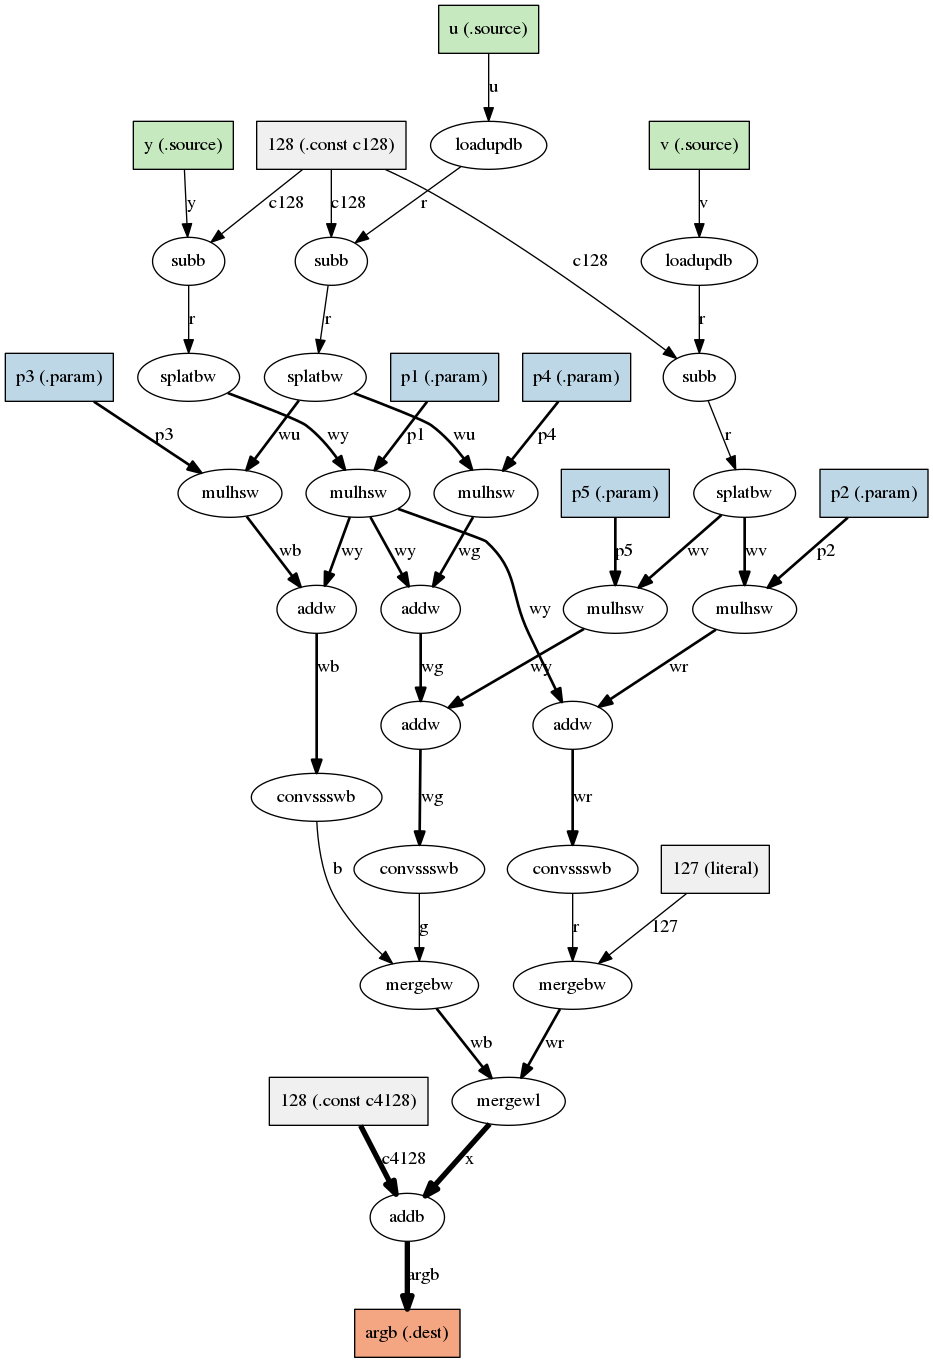

In [2]:
import cStringIO
import subprocess
prog = """
.function video_orc_convert_I420_BGRA
.dest 4 argb guint8
.source 1 y guint8
.source 1 u guint8
.source 1 v guint8
//        data->im[0][0], data->im[0][2],
//        data->im[2][1], data->im[1][1], data->im[1][2], width);
//   p1     p2
// [    p4  p5 ]
//      p3
.param 2 p1  // im[0][0]
.param 2 p2  // im[0][2]
.param 2 p3  // im[2][1]
.param 2 p4  // im[1][1]
.param 2 p5  // im[1][2]
.temp 2 wy
.temp 2 wu
.temp 2 wv
.temp 2 wr
.temp 2 wg
.temp 2 wb
.temp 1 r
.temp 1 g
.temp 1 b
.temp 4 x
.const 1 c128 128
.const 4 c4128 128

subb r, y, c128
splatbw wy, r
loadupdb r, u
subb r, r, c128
splatbw wu, r
loadupdb r, v
subb r, r, c128
splatbw wv, r

mulhsw wy, wy, p1

mulhsw wr, wv, p2
addw wr, wy, wr
convssswb r, wr
mergebw wr, r, 127

mulhsw wb, wu, p3
addw wb, wy, wb
convssswb b, wb

mulhsw wg, wu, p4
addw wg, wy, wg
mulhsw wy, wv, p5
addw wg, wg, wy

convssswb g, wg

mergebw wb, b, g
mergewl x, wb, wr
x4 addb argb, x, c4128
"""
def graph(program):
    sio = cStringIO.StringIO()
    vars = {}
    widths = {}
    dests = []
    sio.write('digraph G {\n')
    for n, line in enumerate(program.split('\n')):
        line = line.strip()
        if not line:
            continue
        sio.write('// {n:>4}: {line}\n'.format(**locals()))
        if line.strip().startswith('//'):
            # Comment
            pass
        elif line.startswith('.'):  # Declarations
            _, opcode, width, args = parse(line)
            if opcode in ['.function', '.flags']:
                continue

            varname = args[0]
            widths[varname] = int(width)
            if opcode == '.dest':
                sio.write("  declare_{varname} [shape=box,label=\"{varname} ({opcode})\",style=\"filled\",fillcolor=\"#f4a582\"];\n".format(**locals()))
                dests.append(varname)
                continue
            elif opcode == '.param':
                sio.write("  declare_{varname} [shape=box,label=\"{varname} ({opcode})\",style=\"filled\",fillcolor=\"#bdd7e7\"];\n".format(**locals()))
            elif opcode == '.source':
                sio.write("  declare_{varname} [shape=box,label=\"{varname} ({opcode})\",style=\"filled\",fillcolor=\"#c7e9c0\"];\n".format(**locals()))
            elif opcode == '.const':
                value = args[1]
                sio.write("  declare_{varname} [shape=box,label=\"{value} ({opcode} {varname})\",style=\"filled\",fillcolor=\"#f0f0f0\"];\n".format(**locals()))
            elif opcode == '.temp':
                pass
            else:
                raise RuntimeError("Unknown line %r" % line)
            vars[varname] = '  declare_{varname}'.format(**locals())
        else:  # Operations
            x, opcode, out, args = parse(line)
            sio.write("  opcode_{n} [label=\"{opcode}\"];\n".format(**locals()))
            for v in args:
                if re.match(r'\d+', v):
                    sio.write("  literal_{v} [shape=box,style=\"filled\",fillcolor=\"#f0f0f0\",label=\"{v} (literal)\"];".format(**locals()))
                    prevln = 'literal_{v}'.format(**locals())
                    weight = 1
                else:
                    weight = widths[v]
                    prevln = vars[v]
                sio.write("  {prevln} -> opcode_{n} [label=\"{v}\",penwidth={weight}];\n".format(**locals()))
            vars[out] = 'opcode_%s' % n

    for dest in dests:
        prevln = vars[dest]
        weight = widths[dest]
        sio.write("  {prevln} -> declare_{dest} [label=\"{dest}\",penwidth={weight}];\n".format(**locals()))

    sio.write('}\n')
    return sio.getvalue()

print graph(prog)
with open('prog.dot', 'w') as f:
    f.write(graph(prog))

with open('prog.png', 'w') as f:
    subprocess.check_call(['dot', '-Tpng', 'prog.dot'], stdout=f)

from IPython.display import Image
Image("prog.png")